In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.8 MB/s eta 0:00:00


In [ ]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, SimpleRNN
import torch
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import roc_curve, auc
from transformers import BertTokenizer, TFBertForSequenceClassification

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_linux_disk = pd.read_csv('drive/MyDrive/ToN_IoT/Train_Test_datasets/Train_Test_Linux_dataset/linux_disk.csv')
#df_linux_memory = pd.read_csv('drive/MyDrive/ToN_IoT/Train_Test_datasets/Train_Test_Linux_dataset/Train_Test_Linux_memory.csv')
df_linux_process = pd.read_csv('drive/MyDrive/ToN_IoT/Train_Test_datasets/Train_Test_Linux_dataset/linux_process.csv')

<ipython-input-3-1d972ee24e14>:1: DtypeWarning: Columns (2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_linux_disk = pd.read_csv('drive/MyDrive/ToN_IoT/Train_Test_datasets/Train_Test_Linux_dataset/linux_disk.csv')


In [ ]:
print("Number of rows: ", df_linux_disk.shape[0])
print("Number of rows: ", df_linux_process.shape[0])

Number of rows:  1048574
Number of rows:  1927968


In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
def filter_scanning(df):
    #change K and M
    def convert_percentage_to_float(value):
      if value == '-':
          value = 0
      if isinstance(value, (float, int)):
          return float(value)
      if value.endswith('%'):
          value = float(value[:-1]) / 100
      return value
    def convert_to_float(value):
      if value == '-':
          value = 0
      if isinstance(value, (float, int)):
          return float(value)
      if value.endswith('K'):
          value = float(value[:-1]) * 1000
      elif value.endswith('M'):
          value = float(value[:-1]) * 1000000
      else:
          value = float(value)
      return value

    df['RDDSK'] = df['RDDSK'].apply(convert_to_float)
    df['WRDSK'] = df['WRDSK'].apply(convert_to_float)
    df['WCANCL'] = df['WCANCL'].apply(convert_to_float)

    df['DSK'] = df['DSK'].apply(convert_percentage_to_float)

    le = LabelEncoder()
    df['CMD'] = le.fit_transform(df['CMD'])

    scanning_count = df[df['type'] == 'scanning'].shape[0]

    # 2. Delete all rows that don't have 'scanning' or 'normal' in the 'type' column
    df = df[df['type'].isin(['scanning', 'normal'])]

    # Filter rows that have 'normal' in the 'type' column
    normal_rows = df[df['type'] == 'normal']

    # Calculate the number of rows to drop
    type_counts = df['type'].value_counts()
    rows_to_drop = type_counts['normal'] - scanning_count

    # Randomly select 'rows_to_drop' row indices to drop
    drop_indices = np.random.choice(normal_rows.index, rows_to_drop, replace=False)

    # Drop the selected rows from the DataFrame
    df = df.drop(drop_indices)

    df.drop(columns=['type'], inplace=True)

    return df

# Load the data
df = df_linux_disk.copy()

df = filter_scanning(df)

features = df[['ts', 'PID', 'RDDSK', 'WRDSK', 'WCANCL', 'DSK', 'CMD']]
target = df['label']

# Create the feature selector
selector = SelectKBest(score_func=f_classif, k='all')

# Fit the selector to the data
selector.fit(features, target)

# Get the scores for each feature
scores = selector.scores_

# Create a DataFrame with the feature names and their scores
scores_df = pd.DataFrame({'feature': features.columns, 'score': scores})

# Print the scores
print(scores_df.sort_values(by='score'))

# Get the feature with the least score
least_effective_feature = scores_df.loc[scores_df['score'].idxmin()]['feature']

print(f"The least effective feature is: {least_effective_feature}")

  feature         score
4  WCANCL      0.371272
3   WRDSK      2.776954
2   RDDSK      5.970417
5     DSK    243.293971
6     CMD    295.879544
1     PID   3915.254500
0      ts  15553.710688
The least effective feature is: WCANCL


---
## Linux_Disk Neural Networks

In [ ]:
  class Model:
      def __init__(self):
          self.fcn = None
          self.rf = None

      def filter_scanning(self, df):
          #change K and M
          def convert_percentage_to_float(value):
            if value == '-':
                value = 0
            if isinstance(value, (float, int)):
                return float(value)
            if value.endswith('%'):
                value = float(value[:-1]) / 100
            return value
          def convert_to_float(value):
            if value == '-':
                value = 0
            if isinstance(value, (float, int)):
                return float(value)
            if value.endswith('K'):
                value = float(value[:-1]) * 1000
            elif value.endswith('M'):
                value = float(value[:-1]) * 1000000
            else:
                value = float(value)
            return value

          df['RDDSK'] = df['RDDSK'].apply(convert_to_float)
          df['WRDSK'] = df['WRDSK'].apply(convert_to_float)
          df['WCANCL'] = df['WCANCL'].apply(convert_to_float)

          df['DSK'] = df['DSK'].apply(convert_percentage_to_float)

          le = LabelEncoder()
          df['CMD'] = le.fit_transform(df['CMD'])

          scanning_count = df[df['type'] == 'scanning'].shape[0]

          # 2. Delete all rows that don't have 'scanning' or 'normal' in the 'type' column
          df = df[df['type'].isin(['scanning', 'normal'])]

          # Filter rows that have 'normal' in the 'type' column
          normal_rows = df[df['type'] == 'normal']

          # Calculate the number of rows to drop
          type_counts = df['type'].value_counts()
          rows_to_drop = type_counts['normal'] - scanning_count

          # Randomly select 'rows_to_drop' row indices to drop
          drop_indices = np.random.choice(normal_rows.index, rows_to_drop, replace=False)

          # Drop the selected rows from the DataFrame
          df = df.drop(drop_indices)

          df.drop(columns=['type', 'WCANCL'], inplace=True)

          return df

      def load_data(self, path):
          # Load the dataset
          df = pd.read_csv(path)
          df = self.filter_scanning(df)

          # Impute missing values with the mean value
          imputer = SimpleImputer(strategy='mean')
          df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

          # Split the dataset into training, validation, and testing sets
          X_trainval, X_test, y_trainval, y_test = train_test_split(df.iloc[:, :-1], df.iloc[:, -1],
                                                                    test_size=0.2, stratify=df.iloc[:, -1],
                                                                    random_state=42)
          X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval,
                                                            test_size=0.25, stratify=y_trainval,
                                                            random_state=42)

          # Normalize the numerical features
          scaler = StandardScaler()
          X_train = scaler.fit_transform(X_train)
          X_val = scaler.transform(X_val)
          X_test = scaler.transform(X_test)

          self.X_train, self.X_val, self.X_test = X_train, X_val, X_test
          self.y_train, self.y_val, self.y_test = y_train, y_val, y_test

      def train_cnn(self, epochs=10, batch_size=32):
          # Reshape the input for the CNN
          X_train_cnn = self.X_train.reshape(self.X_train.shape[0], self.X_train.shape[1], 1)
          X_val_cnn = self.X_val.reshape(self.X_val.shape[0], self.X_val.shape[1], 1)

          # Define the CNN architecture
          self.cnn = tf.keras.models.Sequential([
              Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
              MaxPooling1D(pool_size=2),
              Flatten(),
              Dense(1, activation='sigmoid')
          ])

          # Compile the CNN
          self.cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

          # Train the CNN
          self.cnn.fit(X_train_cnn, self.y_train, validation_data=(X_val_cnn, self.y_val), epochs=epochs, batch_size=batch_size)

      def evaluate_cnn(self):
          # Reshape the input for the CNN
          X_test_cnn = self.X_test.reshape(self.X_test.shape[0], self.X_test.shape[1], 1)

          # Evaluate the CNN
          y_prob = self.cnn.predict(X_test_cnn)
          y_pred = np.round(y_prob).astype(int)
          print('CNN accuracy:', accuracy_score(self.y_test, y_pred))
          print('CNN confusion matrix:\n', confusion_matrix(self.y_test, y_pred))
          print('CNN classification report:\n', classification_report(self.y_test, y_pred, digits=4))

                  # Calculate TPR and FPR
          cm = confusion_matrix(self.y_test, y_pred)
          tn, fp, fn, tp = cm.ravel()
          tpr = tp / (tp + fn)
          fpr = fp / (fp + tn)
          print('CNN TPR:', tpr)
          print('CNN FPR:', fpr)

          # Calculate ROC AUC
          fpr, tpr, _ = roc_curve(self.y_test, y_prob)
          np.save('CNN_fpr.npy', fpr)
          np.save('CNN_tpr.npy', tpr)

          roc_auc = auc(fpr, tpr)
          print('CNN ROC AUC:', roc_auc)

          idx = np.abs(fpr - 0.01).argmin()

          # Get the indices of fpr elements that are less than or equal to 0.01
          indices = np.where(fpr <= 0.01)[0]

          # Get the maximum tpr corresponding to fpr <= 0.01
          max_tpr = tpr[indices].max()

          # Get the index of the maximum tpr
          idx_max_tpr = np.where(tpr == max_tpr)[0][0]

          print("Maximum TPR with FPR <= 0.01: ", max_tpr)
          print("Corresponding FPR: ", fpr[idx_max_tpr])

          # Plot ROC curve
          plt.figure()
          plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
          plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
          plt.xlim([0.0, 1.0])
          plt.ylim([0.0, 1.05])
          plt.xlabel('False Positive Rate')
          plt.ylabel('True Positive Rate')
          plt.title('Receiver Operating Characteristic')
          plt.legend(loc="lower right")
          plt.show()

      def train_lstm(self, epochs=10, batch_size=32):
          # Reshape the input for the LSTM
          X_train_lstm = self.X_train.reshape(self.X_train.shape[0], self.X_train.shape[1], 1)
          X_val_lstm = self.X_val.reshape(self.X_val.shape[0], self.X_val.shape[1], 1)

          # Define the LSTM architecture
          self.lstm = tf.keras.models.Sequential([
              tf.keras.layers.LSTM(32, activation='relu', input_shape=(X_train_lstm.shape[1], 1)),
              tf.keras.layers.Dense(1, activation='sigmoid')
          ])

          # Compile the LSTM
          self.lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

          # Train the LSTM
          self.lstm.fit(X_train_lstm, self.y_train, validation_data=(X_val_lstm, self.y_val), epochs=epochs, batch_size=batch_size)

      def evaluate_lstm(self):
          # Reshape the input for the LSTM
          X_test_lstm = self.X_test.reshape(self.X_test.shape[0], self.X_test.shape[1], 1)

          # Evaluate the LSTM
          y_prob = self.lstm.predict(X_test_lstm)
          y_pred = np.round(y_prob).astype(int)
          print('LSTM accuracy:', accuracy_score(self.y_test, y_pred))
          print('LSTM confusion matrix:\n', confusion_matrix(self.y_test, y_pred))
          print('LSTM classification report:\n', classification_report(self.y_test, y_pred, digits=4))

          # Calculate TPR and FPR
          cm = confusion_matrix(self.y_test, y_pred)
          tn, fp, fn, tp = cm.ravel()
          tpr = tp / (tp + fn)
          fpr = fp / (fp + tn)
          print('LSTM TPR:', tpr)
          print('LSTM FPR:', fpr)

          # Calculate ROC AUC
          fpr, tpr, _ = roc_curve(self.y_test, y_prob)
          np.save('LSTM_fpr.npy', fpr)
          np.save('LSTM_tpr.npy', tpr)
          roc_auc = auc(fpr, tpr)
          print('LSTM ROC AUC:', roc_auc)

          idx = np.abs(fpr - 0.01).argmin()

          # Get the indices of fpr elements that are less than or equal to 0.01
          indices = np.where(fpr <= 0.01)[0]

          # Get the maximum tpr corresponding to fpr <= 0.01
          max_tpr = tpr[indices].max()

          # Get the index of the maximum tpr
          idx_max_tpr = np.where(tpr == max_tpr)[0][0]

          print("Maximum TPR with FPR <= 0.01: ", max_tpr)
          print("Corresponding FPR: ", fpr[idx_max_tpr])

          # Plot ROC curve
          plt.figure()
          plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
          plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
          plt.xlim([0.0, 1.0])
          plt.ylim([0.0, 1.05])
          plt.xlabel('False Positive Rate')
          plt.ylabel('True Positive Rate')
          plt.title('Receiver Operating Characteristic')
          plt.legend(loc="lower right")
          plt.show()

      def train_fcn(self, epochs=10, batch_size=32):
          # Define the FCN architecture
          self.fcn = tf.keras.models.Sequential([
              tf.keras.layers.Dense(32, activation='relu', input_shape=(self.X_train.shape[1],)),
              tf.keras.layers.Dense(1, activation='sigmoid')
          ])

          # Compile the FCN
          self.fcn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

          # Train the FCN
          self.fcn.fit(self.X_train, self.y_train, validation_data=(self.X_val, self.y_val), epochs=epochs, batch_size=batch_size)

      def evaluate_fcn(self):
          # Evaluate the FCN
          y_prob = self.fcn.predict(self.X_test)
          y_pred = np.round(y_prob).astype(int)
          print('FCN accuracy:', accuracy_score(self.y_test, y_pred))
          print('FCN confusion matrix:\n', confusion_matrix(self.y_test, y_pred))
          print('FCN classification report:\n', classification_report(self.y_test, y_pred, digits=4))

          # Calculate TPR and FPR
          cm = confusion_matrix(self.y_test, y_pred)
          tn, fp, fn, tp = cm.ravel()
          tpr = tp / (tp + fn)
          fpr = fp / (fp + tn)
          print('FCN TPR:', tpr)
          print('FCN FPR:', fpr)

          # Calculate ROC AUC
          fpr, tpr, _ = roc_curve(self.y_test, y_prob)

          np.save('FCN_fpr.npy', fpr)
          np.save('FCN_tpr.npy', tpr)

          roc_auc = auc(fpr, tpr)
          print('FCN ROC AUC:', roc_auc)
          idx = np.abs(fpr - 0.01).argmin()
          indices = np.where(fpr <= 0.01)[0]
          max_tpr = tpr[indices].max()
          idx_max_tpr = np.where(tpr == max_tpr)[0][0]

          print("Maximum TPR with FPR <= 0.01: ", max_tpr)
          print("Corresponding FPR: ", fpr[idx_max_tpr])

          # Plot ROC curve
          plt.figure()
          plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
          plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
          plt.xlim([0.0, 1.0])
          plt.ylim([0.0, 1.05])
          plt.xlabel('False Positive Rate')
          plt.ylabel('True Positive Rate')
          plt.title('Receiver Operating Characteristic')
          plt.legend(loc="lower right")
          plt.show()

      def train_cnn_lstm(self, epochs=10, batch_size=32):
          # Reshape the input for the CNN-LSTM
          X_train_cnn_lstm = self.X_train.reshape(self.X_train.shape[0], self.X_train.shape[1], 1)
          X_val_cnn_lstm = self.X_val.reshape(self.X_val.shape[0], self.X_val.shape[1], 1)

          # Define the CNN-LSTM architecture
          self.cnn_lstm = tf.keras.models.Sequential([
              Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train_cnn_lstm.shape[1], 1)),
              MaxPooling1D(pool_size=2),
              LSTM(64),
              Dense(1, activation='sigmoid')
          ])

          # Compile the CNN-LSTM
          self.cnn_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

          # Train the CNN-LSTM
          self.cnn_lstm.fit(X_train_cnn_lstm, self.y_train, validation_data=(X_val_cnn_lstm, self.y_val), epochs=epochs, batch_size=batch_size)

      def evaluate_cnn_lstm(self):
          # Reshape the input for the CNN-LSTM
          X_test_cnn_lstm = self.X_test.reshape(self.X_test.shape[0], self.X_test.shape[1], 1)

          # Evaluate the CNN-LSTM
          y_prob = self.cnn_lstm.predict(X_test_cnn_lstm)
          y_pred = np.round(y_prob).astype(int)
          print('CNN-LSTM accuracy:', accuracy_score(self.y_test, y_pred))
          print('CNN-LSTM confusion matrix:\n', confusion_matrix(self.y_test, y_pred))
          print('CNN-LSTM classification report:\n', classification_report(self.y_test, y_pred, digits=4))

          # Calculate TPR and FPR
          cm = confusion_matrix(self.y_test, y_pred)
          tn, fp, fn, tp = cm.ravel()
          tpr = tp / (tp + fn)
          fpr = fp / (fp + tn)
          print('CNN-LSTM TPR:', tpr)
          print('CNN-LSTM FPR:', fpr)

          # Calculate ROC AUC
          fpr, tpr, _ = roc_curve(self.y_test, y_prob)

          np.save('CNN_LSTM_fpr.npy', fpr)
          np.save('CNN_LSTM_tpr.npy', tpr)

          roc_auc = auc(fpr, tpr)
          print('FCN ROC AUC:', roc_auc)
          idx = np.abs(fpr - 0.01).argmin()
          indices = np.where(fpr <= 0.01)[0]
          max_tpr = tpr[indices].max()
          idx_max_tpr = np.where(tpr == max_tpr)[0][0]

          print("Maximum TPR with FPR <= 0.01: ", max_tpr)
          print("Corresponding FPR: ", fpr[idx_max_tpr])

          # Plot ROC curve
          plt.figure()
          plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
          plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
          plt.xlim([0.0, 1.0])
          plt.ylim([0.0, 1.05])
          plt.xlabel('False Positive Rate')
          plt.ylabel('True Positive Rate')
          plt.title('Receiver Operating Characteristic')
          plt.legend(loc="lower right")
          plt.show()

      def train_rf(self, n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1):
          # Define the Random Forest classifier
          self.rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                            min_samples_split=min_samples_split,
                                            min_samples_leaf=min_samples_leaf,
                                            random_state=42)

          # Train the Random Forest classifier
          self.rf.fit(self.X_train, self.y_train)

      def evaluate_rf(self):
          # Evaluate the Random Forest classifier
          y_pred = self.rf.predict(self.X_test)
          print('RF accuracy:', accuracy_score(self.y_test, y_pred))
          print('RF confusion matrix:\n', confusion_matrix(self.y_test, y_pred))
          print('RF classification report:\n', classification_report(self.y_test, y_pred, digits=4))

          # Calculate TPR and FPR
          cm = confusion_matrix(self.y_test, y_pred)
          tn, fp, fn, tp = cm.ravel()
          tpr = tp / (tp + fn)
          fpr = fp / (fp + tn)
          print('RF TPR:', tpr)
          print('RF FPR:', fpr)

      def train_rnn(self, epochs=10, batch_size=32):
          # Reshape the input for the RNN
          X_train_rnn = self.X_train.reshape(self.X_train.shape[0], self.X_train.shape[1], 1)
          X_val_rnn = self.X_val.reshape(self.X_val.shape[0], self.X_val.shape[1], 1)

          # Define the RNN architecture
          self.rnn = tf.keras.models.Sequential([
              SimpleRNN(32, activation='relu', input_shape=(X_train_rnn.shape[1], 1)),
              Dense(1, activation='sigmoid')
          ])

          # Compile the RNN
          self.rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

          # Train the RNN
          self.rnn.fit(X_train_rnn, self.y_train, validation_data=(X_val_rnn, self.y_val), epochs=epochs, batch_size=batch_size)

      def evaluate_rnn(self):
          # Reshape the input for the RNN
          X_test_rnn = self.X_test.reshape(self.X_test.shape[0], self.X_test.shape[1], 1)

          # Evaluate the RNN
          y_prob = self.rnn.predict(X_test_rnn)
          y_pred = np.round(y_prob).astype(int)
          print('RNN accuracy:', accuracy_score(self.y_test, y_pred))
          print('RNN confusion matrix:\n', confusion_matrix(self.y_test, y_pred))
          print('RNN classification report:\n', classification_report(self.y_test, y_pred, digits=4))

          # Calculate TPR and FPR
          cm = confusion_matrix(self.y_test, y_pred)
          tn, fp, fn, tp = cm.ravel()
          tpr = tp / (tp + fn)
          fpr = fp / (fp + tn)
          print('RNN TPR:', tpr)
          print('RNN FPR:', fpr)

          # Calculate ROC AUC
          fpr, tpr, _ = roc_curve(self.y_test, y_prob)
          np.save('RNN_fpr.npy', fpr)
          np.save('RNN_tpr.npy', tpr)

          roc_auc = auc(fpr, tpr)
          print('FCN ROC AUC:', roc_auc)

          idx = np.abs(fpr - 0.01).argmin()

          # Get the indices of fpr elements that are less than or equal to 0.05
          indices = np.where(fpr <= 0.01)[0]

          # Get the maximum tpr corresponding to fpr <= 0.01
          max_tpr = tpr[indices].max()

          # Get the index of the maximum tpr
          idx_max_tpr = np.where(tpr == max_tpr)[0][0]

          print("Maximum TPR with FPR <= 0.01: ", max_tpr)

          # Plot ROC curve
          plt.figure()
          plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
          plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
          plt.xlim([0.0, 1.0])
          plt.ylim([0.0, 1.05])
          plt.xlabel('False Positive Rate')
          plt.ylabel('True Positive Rate')
          plt.title('Receiver Operating Characteristic')
          plt.legend(loc="lower right")
          plt.show()

      def train_ann(self, epochs=10, batch_size=32):
          # Define the ANN architecture
          self.ann = tf.keras.models.Sequential([
              tf.keras.layers.Dense(32, activation='relu', input_shape=(self.X_train.shape[1],)),
              tf.keras.layers.Dense(64, activation='relu'),
              tf.keras.layers.Dense(1, activation='sigmoid')
          ])

          # Compile the ANN
          self.ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

          # Train the ANN
          self.ann.fit(self.X_train, self.y_train, validation_data=(self.X_val, self.y_val), epochs=epochs, batch_size=batch_size)

      def evaluate_ann(self):
          # Evaluate the ANN
          y_prob = self.ann.predict(self.X_test)
          y_pred = np.round(y_prob).astype(int)
          print('ANN accuracy:', accuracy_score(self.y_test, y_pred))
          print('ANN confusion matrix:\n', confusion_matrix(self.y_test, y_pred))
          print('ANN classification report:\n', classification_report(self.y_test, y_pred, digits=4))

          # Calculate TPR and FPR
          cm = confusion_matrix(self.y_test, y_pred)
          tn, fp, fn, tp = cm.ravel()
          tpr = tp / (tp + fn)
          fpr = fp / (fp + tn)
          print('ANN TPR:', tpr)
          print('ANN FPR:', fpr)

          # Calculate ROC AUC
          fpr, tpr, _ = roc_curve(self.y_test, y_prob)
          np.save('ANN_fpr.npy', fpr)
          np.save('ANN_tpr.npy', tpr)
          roc_auc = auc(fpr, tpr)
          print('FCN ROC AUC:', roc_auc)
          idx = np.abs(fpr - 0.01).argmin()
          indices = np.where(fpr <= 0.01)[0]
          max_tpr = tpr[indices].max()
          idx_max_tpr = np.where(tpr == max_tpr)[0][0]

          print("Maximum TPR with FPR <= 0.01: ", max_tpr)
          print("Corresponding FPR: ", fpr[idx_max_tpr])

          # Plot ROC curve
          plt.figure()
          plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
          plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
          plt.xlim([0.0, 1.0])
          plt.ylim([0.0, 1.05])
          plt.xlabel('False Positive Rate')
          plt.ylabel('True Positive Rate')
          plt.title('Receiver Operating Characteristic')
          plt.legend(loc="lower right")
          plt.show()

In [ ]:
clf=Model()

In [ ]:
clf.load_data('drive/MyDrive/ToN_IoT/Train_Test_datasets/Train_Test_Linux_dataset/linux_disk.csv')

<ipython-input-19-37c9fa9d8f6e>:62: DtypeWarning: Columns (2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Epoch 1/10
2391/2391 [==============================] - 24s 7ms/step - loss: 0.4399 - accuracy: 0.8400 - val_loss: 0.3652 - val_accuracy: 0.8807
Epoch 2/10
2391/2391 [==============================] - 13s 6ms/step - loss: 0.3510 - accuracy: 0.8803 - val_loss: 0.3337 - val_accuracy: 0.8759
Epoch 3/10
2391/2391 [==============================] - 13s 6ms/step - loss: 0.3235 - accuracy: 0.8806 - val_loss: 0.3177 - val_accuracy: 0.8783
Epoch 4/10
2391/2391 [==============================] - 12s 5ms/step - loss: 0.3130 - accuracy: 0.8839 - val_loss: 0.3101 - val_accuracy: 0.8883
Epoch 5/10
2391/2391 [==============================] - 12s 5ms/step - loss: 0.3066 - accuracy: 0.8879 - val_loss: 0.3048 - val_accuracy: 0.8891
Epoch 6/10
2391/2391 [==============================] - 12s 5ms/step - loss: 0.3018 - accuracy: 0.8909 - val_loss: 0.3023 - val_accuracy: 0.8909
Epoch 7/10
2391/2391 [==============================] - 13s 6ms/step - loss: 0.2977 - accuracy: 0.8925 - val_loss: 0.3004 - val_ac

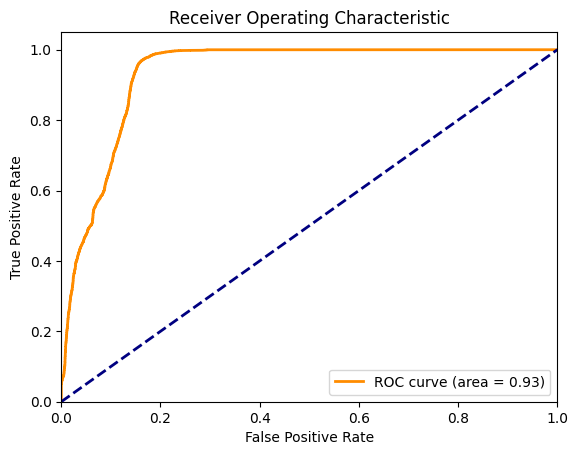

In [ ]:
clf.train_cnn()
clf.evaluate_cnn()

Epoch 1/10
2391/2391 [==============================] - 52s 21ms/step - loss: 0.3152 - accuracy: 0.8771 - val_loss: 0.2688 - val_accuracy: 0.9036
Epoch 2/10
2391/2391 [==============================] - 50s 21ms/step - loss: 0.2637 - accuracy: 0.8996 - val_loss: 0.2739 - val_accuracy: 0.8895
Epoch 3/10
2391/2391 [==============================] - 48s 20ms/step - loss: 0.2530 - accuracy: 0.9014 - val_loss: 0.2284 - val_accuracy: 0.9040
Epoch 4/10
2391/2391 [==============================] - 48s 20ms/step - loss: 0.2162 - accuracy: 0.9106 - val_loss: 0.1939 - val_accuracy: 0.9247
Epoch 5/10
2391/2391 [==============================] - 60s 25ms/step - loss: 0.1836 - accuracy: 0.9328 - val_loss: 0.1624 - val_accuracy: 0.9400
Epoch 6/10
2391/2391 [==============================] - 51s 21ms/step - loss: 0.1707 - accuracy: 0.9391 - val_loss: 0.1639 - val_accuracy: 0.9401
Epoch 7/10
2391/2391 [==============================] - 48s 20ms/step - loss: 0.1645 - accuracy: 0.9422 - val_loss: 0.1566 -

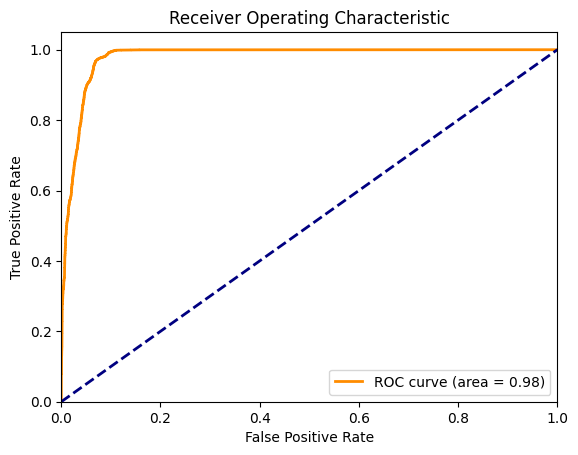

In [ ]:
clf.train_lstm()
clf.evaluate_lstm()

Epoch 1/10
2391/2391 [==============================] - 13s 5ms/step - loss: 0.3654 - accuracy: 0.8621 - val_loss: 0.3027 - val_accuracy: 0.8876
Epoch 2/10
2391/2391 [==============================] - 11s 5ms/step - loss: 0.2887 - accuracy: 0.8881 - val_loss: 0.2785 - val_accuracy: 0.8911
Epoch 3/10
2391/2391 [==============================] - 11s 4ms/step - loss: 0.2733 - accuracy: 0.8945 - val_loss: 0.2701 - val_accuracy: 0.8956
Epoch 4/10
2391/2391 [==============================] - 13s 5ms/step - loss: 0.2667 - accuracy: 0.8976 - val_loss: 0.2638 - val_accuracy: 0.8968
Epoch 5/10
2391/2391 [==============================] - 12s 5ms/step - loss: 0.2617 - accuracy: 0.9001 - val_loss: 0.2606 - val_accuracy: 0.9006
Epoch 6/10
2391/2391 [==============================] - 10s 4ms/step - loss: 0.2582 - accuracy: 0.9023 - val_loss: 0.2568 - val_accuracy: 0.9010
Epoch 7/10
2391/2391 [==============================] - 12s 5ms/step - loss: 0.2543 - accuracy: 0.9060 - val_loss: 0.2535 - val_ac

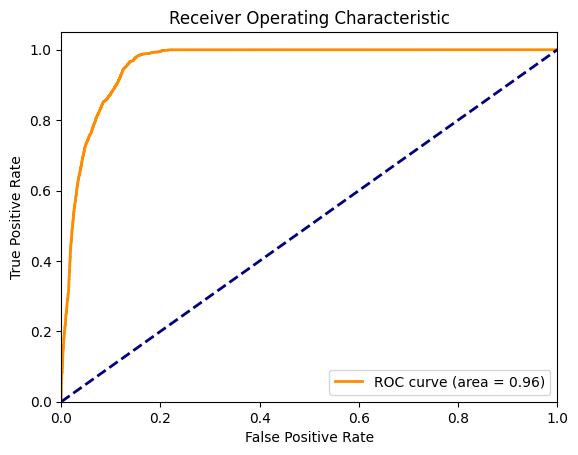

In [ ]:
clf.train_fcn()
clf.evaluate_fcn()

#FCN TPR: 0.979370931053416
#Maximum TPR with FPR <= 0.01:  0.8785787120558475

Epoch 1/10
2391/2391 [==============================] - 20s 7ms/step - loss: 0.3079 - accuracy: 0.8833 - val_loss: 0.2687 - val_accuracy: 0.8972
Epoch 2/10
2391/2391 [==============================] - 18s 7ms/step - loss: 0.2551 - accuracy: 0.9070 - val_loss: 0.2473 - val_accuracy: 0.9129
Epoch 3/10
2391/2391 [==============================] - 17s 7ms/step - loss: 0.2462 - accuracy: 0.9090 - val_loss: 0.2318 - val_accuracy: 0.9126
Epoch 4/10
2391/2391 [==============================] - 18s 8ms/step - loss: 0.2114 - accuracy: 0.9141 - val_loss: 0.2115 - val_accuracy: 0.9206
Epoch 5/10
2391/2391 [==============================] - 18s 7ms/step - loss: 0.1790 - accuracy: 0.9360 - val_loss: 0.1698 - val_accuracy: 0.9400
Epoch 6/10
2391/2391 [==============================] - 18s 7ms/step - loss: 0.1679 - accuracy: 0.9412 - val_loss: 0.1590 - val_accuracy: 0.9440
Epoch 7/10
2391/2391 [==============================] - 20s 9ms/step - loss: 0.1613 - accuracy: 0.9428 - val_loss: 0.1601 - val_ac

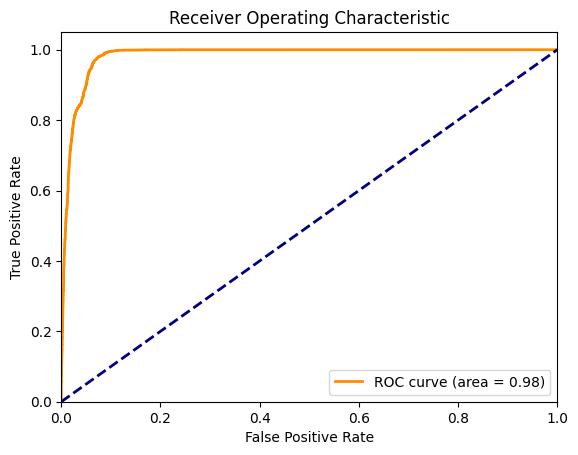

In [ ]:
clf.train_cnn_lstm()
clf.evaluate_cnn_lstm()

#CNN-LSTM TPR: 0.9710565534551729 (8.2%)
#Maximum TPR with FPR <= 0.01:  0.9504274845085889

Epoch 1/10
2391/2391 [==============================] - 28s 11ms/step - loss: 0.2450 - accuracy: 0.9014 - val_loss: 0.1784 - val_accuracy: 0.9329
Epoch 2/10
2391/2391 [==============================] - 24s 10ms/step - loss: 0.1672 - accuracy: 0.9409 - val_loss: 0.1599 - val_accuracy: 0.9420
Epoch 3/10
2391/2391 [==============================] - 27s 11ms/step - loss: 0.1571 - accuracy: 0.9441 - val_loss: 0.1495 - val_accuracy: 0.9443
Epoch 4/10
2391/2391 [==============================] - 25s 10ms/step - loss: 0.1525 - accuracy: 0.9449 - val_loss: 0.1436 - val_accuracy: 0.9498
Epoch 5/10
2391/2391 [==============================] - 26s 11ms/step - loss: 0.1492 - accuracy: 0.9456 - val_loss: 0.1423 - val_accuracy: 0.9478
Epoch 6/10
2391/2391 [==============================] - 25s 10ms/step - loss: 0.1467 - accuracy: 0.9454 - val_loss: 0.1465 - val_accuracy: 0.9477
Epoch 7/10
2391/2391 [==============================] - 25s 10ms/step - loss: 0.1440 - accuracy: 0.9457 - val_loss: 0.1379 -

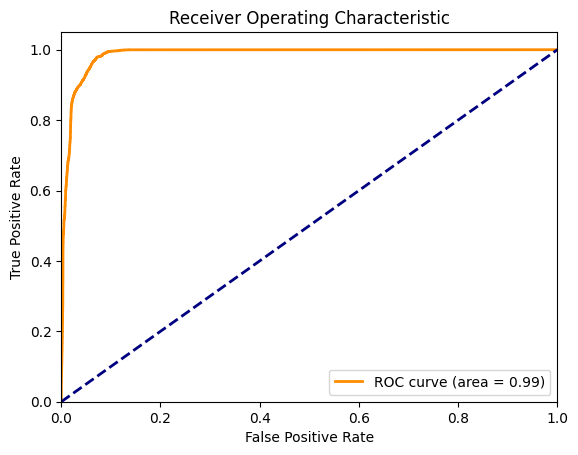

In [ ]:
clf.train_rnn()
clf.evaluate_rnn()

#RNN TPR: 0.9675268648521452 (6% FPR)
#Maximum TPR with FPR <= 0.01:  0.9788218683818338

Epoch 1/10
2391/2391 [==============================] - 14s 5ms/step - loss: 0.2988 - accuracy: 0.8867 - val_loss: 0.2597 - val_accuracy: 0.9007
Epoch 2/10
2391/2391 [==============================] - 13s 5ms/step - loss: 0.2493 - accuracy: 0.9070 - val_loss: 0.2404 - val_accuracy: 0.9105
Epoch 3/10
2391/2391 [==============================] - 12s 5ms/step - loss: 0.2299 - accuracy: 0.9107 - val_loss: 0.2129 - val_accuracy: 0.9165
Epoch 4/10
2391/2391 [==============================] - 14s 6ms/step - loss: 0.1943 - accuracy: 0.9219 - val_loss: 0.1792 - val_accuracy: 0.9335
Epoch 5/10
2391/2391 [==============================] - 14s 6ms/step - loss: 0.1753 - accuracy: 0.9375 - val_loss: 0.1756 - val_accuracy: 0.9375
Epoch 6/10
2391/2391 [==============================] - 13s 5ms/step - loss: 0.1668 - accuracy: 0.9418 - val_loss: 0.1672 - val_accuracy: 0.9411
Epoch 7/10
2391/2391 [==============================] - 11s 5ms/step - loss: 0.1613 - accuracy: 0.9440 - val_loss: 0.1592 - val_ac

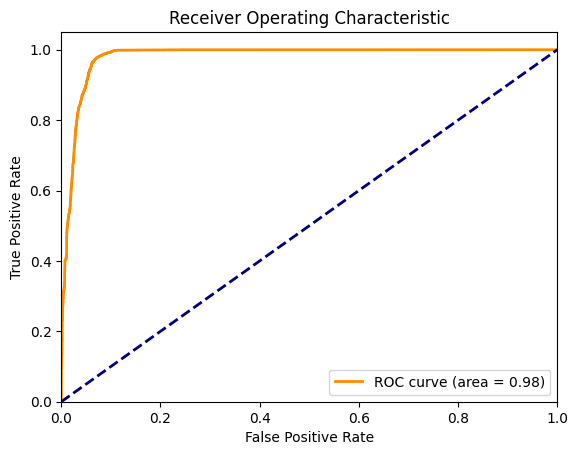

In [ ]:
clf.train_ann()
clf.evaluate_ann()

#ANN TPR: 0.9871362459800769
#Maximum TPR with FPR <= 0.01:  0.9688603027688446

In [ ]:
clf.train_rf()
clf.evaluate_rf()

#RF TPR: 0.9967840614950192

---
## Linux_Process Neural Networks

In [ ]:
class Model:
    def __init__(self):
        self.fcn = None
        self.rf = None

    def preprocess_linux_process(self, df):
        le = LabelEncoder()
        df['POLI'] = le.fit_transform(df['POLI'])
        df['Status'] = le.fit_transform(df['Status'])
        df['State'] = le.fit_transform(df['State'])
        df['CMD'] = le.fit_transform(df['CMD'])

        scanning_count = df[df['type'] == 'scanning'].shape[0]

        # 2. Delete all rows that don't have 'scanning' or 'normal' in the 'type' column
        df = df[df['type'].isin(['scanning', 'normal'])]

        # Filter rows that have 'normal' in the 'type' column
        normal_rows = df[df['type'] == 'normal']

        # Calculate the number of rows to drop
        type_counts = df['type'].value_counts()
        rows_to_drop = type_counts['normal'] - scanning_count

        # Randomly select 'rows_to_drop' row indices to drop
        drop_indices = np.random.choice(normal_rows.index, rows_to_drop, replace=False)

        # Drop the selected rows from the DataFrame
        df = df.drop(drop_indices)

        df.drop(columns=['type'], inplace=True)

        return df

    def load_data(self, path):
        # Load the dataset
        df = pd.read_csv(path)
        df = self.preprocess_linux_process(df)

        # Impute missing values with the mean value
        imputer = SimpleImputer(strategy='mean')
        df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

        # Split the dataset into training, validation, and testing sets
        X_trainval, X_test, y_trainval, y_test = train_test_split(df.iloc[:, :-1], df.iloc[:, -1],
                                                                  test_size=0.2, stratify=df.iloc[:, -1],
                                                                  random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval,
                                                          test_size=0.25, stratify=y_trainval,
                                                          random_state=42)

        # Normalize the numerical features
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)

        self.X_train, self.X_val, self.X_test = X_train, X_val, X_test
        self.y_train, self.y_val, self.y_test = y_train, y_val, y_test
    def train_cnn(self, epochs=10, batch_size=32):
        # Reshape the input for the CNN
        X_train_cnn = self.X_train.reshape(self.X_train.shape[0], self.X_train.shape[1], 1)
        X_val_cnn = self.X_val.reshape(self.X_val.shape[0], self.X_val.shape[1], 1)

        # Define the CNN architecture
        self.cnn = tf.keras.models.Sequential([
            Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
            MaxPooling1D(pool_size=2),
            Flatten(),
            Dense(1, activation='sigmoid')
        ])

        # Compile the CNN
        self.cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Train the CNN
        self.cnn.fit(X_train_cnn, self.y_train, validation_data=(X_val_cnn, self.y_val), epochs=epochs, batch_size=batch_size)

    def evaluate_cnn(self):
        # Reshape the input for the CNN
        X_test_cnn = self.X_test.reshape(self.X_test.shape[0], self.X_test.shape[1], 1)

        # Evaluate the CNN
        y_prob = self.cnn.predict(X_test_cnn)
        y_pred = np.round(y_prob).astype(int)
        print('CNN accuracy:', accuracy_score(self.y_test, y_pred))
        print('CNN confusion matrix:\n', confusion_matrix(self.y_test, y_pred))
        print('CNN classification report:\n', classification_report(self.y_test, y_pred, digits=4))

                # Calculate TPR and FPR
        cm = confusion_matrix(self.y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        print('CNN TPR:', tpr)
        print('CNN FPR:', fpr)

        # Calculate ROC AUC
        fpr, tpr, _ = roc_curve(self.y_test, y_prob)
        np.save('CNN_fpr.npy', fpr)
        np.save('CNN_tpr.npy', tpr)
        roc_auc = auc(fpr, tpr)
        print('CNN ROC AUC:', roc_auc)

        idx = np.abs(fpr - 0.01).argmin()

        # Get the indices of fpr elements that are less than or equal to 0.01
        indices = np.where(fpr <= 0.01)[0]

        # Get the maximum tpr corresponding to fpr <= 0.01
        max_tpr = tpr[indices].max()

        # Get the index of the maximum tpr
        idx_max_tpr = np.where(tpr == max_tpr)[0][0]

        print("Maximum TPR with FPR <= 0.01: ", max_tpr)
        print("Corresponding FPR: ", fpr[idx_max_tpr])

        # Plot ROC curve
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

    def train_lstm(self, epochs=10, batch_size=32):
        # Reshape the input for the LSTM
        X_train_lstm = self.X_train.reshape(self.X_train.shape[0], self.X_train.shape[1], 1)
        X_val_lstm = self.X_val.reshape(self.X_val.shape[0], self.X_val.shape[1], 1)

        # Define the LSTM architecture
        self.lstm = tf.keras.models.Sequential([
            tf.keras.layers.LSTM(32, activation='relu', input_shape=(X_train_lstm.shape[1], 1)),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        # Compile the LSTM
        self.lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Train the LSTM
        self.lstm.fit(X_train_lstm, self.y_train, validation_data=(X_val_lstm, self.y_val), epochs=epochs, batch_size=batch_size)

    def evaluate_lstm(self):
        # Reshape the input for the LSTM
        X_test_lstm = self.X_test.reshape(self.X_test.shape[0], self.X_test.shape[1], 1)

        # Evaluate the LSTM
        y_prob = self.lstm.predict(X_test_lstm)
        y_pred = np.round(y_prob).astype(int)
        print('LSTM accuracy:', accuracy_score(self.y_test, y_pred))
        print('LSTM confusion matrix:\n', confusion_matrix(self.y_test, y_pred))
        print('LSTM classification report:\n', classification_report(self.y_test, y_pred, digits=4))

        # Calculate TPR and FPR
        cm = confusion_matrix(self.y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        print('LSTM TPR:', tpr)
        print('LSTM FPR:', fpr)

        # Calculate ROC AUC
        fpr, tpr, _ = roc_curve(self.y_test, y_prob)
        np.save('LSTM_fpr.npy', fpr)
        np.save('LSTM_tpr.npy', tpr)
        roc_auc = auc(fpr, tpr)
        print('LSTM ROC AUC:', roc_auc)

        idx = np.abs(fpr - 0.01).argmin()

        # Get the indices of fpr elements that are less than or equal to 0.01
        indices = np.where(fpr <= 0.01)[0]

        # Get the maximum tpr corresponding to fpr <= 0.01
        max_tpr = tpr[indices].max()

        # Get the index of the maximum tpr
        idx_max_tpr = np.where(tpr == max_tpr)[0][0]

        print("Maximum TPR with FPR <= 0.01: ", max_tpr)
        print("Corresponding FPR: ", fpr[idx_max_tpr])

        # Plot ROC curve
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

    def train_fcn(self, epochs=10, batch_size=32):
        # Define the FCN architecture
        self.fcn = tf.keras.models.Sequential([
            tf.keras.layers.Dense(32, activation='relu', input_shape=(self.X_train.shape[1],)),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        # Compile the FCN
        self.fcn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Train the FCN
        self.fcn.fit(self.X_train, self.y_train, validation_data=(self.X_val, self.y_val), epochs=epochs, batch_size=batch_size)

    def evaluate_fcn(self):
        # Evaluate the FCN
        y_prob = self.fcn.predict(self.X_test)
        y_pred = np.round(y_prob).astype(int)
        print('FCN accuracy:', accuracy_score(self.y_test, y_pred))
        print('FCN confusion matrix:\n', confusion_matrix(self.y_test, y_pred))
        print('FCN classification report:\n', classification_report(self.y_test, y_pred, digits=4))

        # Calculate TPR and FPR
        cm = confusion_matrix(self.y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        print('FCN TPR:', tpr)
        print('FCN FPR:', fpr)

        # Calculate ROC AUC
        fpr, tpr, _ = roc_curve(self.y_test, y_prob)
        np.save('FCN_fpr.npy', fpr)
        np.save('FCN_tpr.npy', tpr)
        roc_auc = auc(fpr, tpr)
        print('FCN ROC AUC:', roc_auc)
        idx = np.abs(fpr - 0.01).argmin()
        indices = np.where(fpr <= 0.01)[0]
        max_tpr = tpr[indices].max()
        idx_max_tpr = np.where(tpr == max_tpr)[0][0]

        print("Maximum TPR with FPR <= 0.01: ", max_tpr)
        print("Corresponding FPR: ", fpr[idx_max_tpr])

        # Plot ROC curve
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

    def train_cnn_lstm(self, epochs=10, batch_size=32):
        # Reshape the input for the CNN-LSTM
        X_train_cnn_lstm = self.X_train.reshape(self.X_train.shape[0], self.X_train.shape[1], 1)
        X_val_cnn_lstm = self.X_val.reshape(self.X_val.shape[0], self.X_val.shape[1], 1)

        # Define the CNN-LSTM architecture
        self.cnn_lstm = tf.keras.models.Sequential([
            Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train_cnn_lstm.shape[1], 1)),
            MaxPooling1D(pool_size=2),
            LSTM(64),
            Dense(1, activation='sigmoid')
        ])

        # Compile the CNN-LSTM
        self.cnn_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Train the CNN-LSTM
        self.cnn_lstm.fit(X_train_cnn_lstm, self.y_train, validation_data=(X_val_cnn_lstm, self.y_val), epochs=epochs, batch_size=batch_size)

    def evaluate_cnn_lstm(self):
        # Reshape the input for the CNN-LSTM
        X_test_cnn_lstm = self.X_test.reshape(self.X_test.shape[0], self.X_test.shape[1], 1)

        # Evaluate the CNN-LSTM
        y_prob = self.cnn_lstm.predict(X_test_cnn_lstm)
        y_pred = np.round(y_prob).astype(int)
        print('CNN-LSTM accuracy:', accuracy_score(self.y_test, y_pred))
        print('CNN-LSTM confusion matrix:\n', confusion_matrix(self.y_test, y_pred))
        print('CNN-LSTM classification report:\n', classification_report(self.y_test, y_pred, digits=4))

        # Calculate TPR and FPR
        cm = confusion_matrix(self.y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        print('CNN-LSTM TPR:', tpr)
        print('CNN-LSTM FPR:', fpr)

        # Calculate ROC AUC
        fpr, tpr, _ = roc_curve(self.y_test, y_prob)
        np.save('CNN_LSTM_fpr.npy', fpr)
        np.save('CNN_LSTM_tpr.npy', tpr)
        roc_auc = auc(fpr, tpr)
        print('FCN ROC AUC:', roc_auc)
        idx = np.abs(fpr - 0.01).argmin()
        indices = np.where(fpr <= 0.01)[0]
        max_tpr = tpr[indices].max()
        idx_max_tpr = np.where(tpr == max_tpr)[0][0]

        print("Maximum TPR with FPR <= 0.01: ", max_tpr)
        print("Corresponding FPR: ", fpr[idx_max_tpr])

        # Plot ROC curve
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

    def train_rf(self, n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        # Define the Random Forest classifier
        self.rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                          min_samples_split=min_samples_split,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)

        # Train the Random Forest classifier
        self.rf.fit(self.X_train, self.y_train)

    def evaluate_rf(self):
        # Evaluate the Random Forest classifier
        y_pred = self.rf.predict(self.X_test)
        print('RF accuracy:', accuracy_score(self.y_test, y_pred))
        print('RF confusion matrix:\n', confusion_matrix(self.y_test, y_pred))
        print('RF classification report:\n', classification_report(self.y_test, y_pred, digits=4))

        # Calculate TPR and FPR
        cm = confusion_matrix(self.y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        print('RF TPR:', tpr)
        print('RF FPR:', fpr)

    def train_rnn(self, epochs=10, batch_size=32):
        # Reshape the input for the RNN
        X_train_rnn = self.X_train.reshape(self.X_train.shape[0], self.X_train.shape[1], 1)
        X_val_rnn = self.X_val.reshape(self.X_val.shape[0], self.X_val.shape[1], 1)

        # Define the RNN architecture
        self.rnn = tf.keras.models.Sequential([
            SimpleRNN(32, activation='relu', input_shape=(X_train_rnn.shape[1], 1)),
            Dense(1, activation='sigmoid')
        ])

        # Compile the RNN
        self.rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Train the RNN
        self.rnn.fit(X_train_rnn, self.y_train, validation_data=(X_val_rnn, self.y_val), epochs=epochs, batch_size=batch_size)

    def evaluate_rnn(self):
        # Reshape the input for the RNN
        X_test_rnn = self.X_test.reshape(self.X_test.shape[0], self.X_test.shape[1], 1)

        # Evaluate the RNN
        y_prob = self.rnn.predict(X_test_rnn)
        y_pred = np.round(y_prob).astype(int)
        print('RNN accuracy:', accuracy_score(self.y_test, y_pred))
        print('RNN confusion matrix:\n', confusion_matrix(self.y_test, y_pred))
        print('RNN classification report:\n', classification_report(self.y_test, y_pred, digits=4))

        # Calculate TPR and FPR
        cm = confusion_matrix(self.y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        print('RNN TPR:', tpr)
        print('RNN FPR:', fpr)

        # Calculate ROC AUC
        fpr, tpr, _ = roc_curve(self.y_test, y_prob)
        np.save('RNN_fpr.npy', fpr)
        np.save('RNN_tpr.npy', tpr)
        roc_auc = auc(fpr, tpr)
        print('FCN ROC AUC:', roc_auc)
        idx = np.abs(fpr - 0.011).argmin()
        indices = np.where(fpr <= 0.011)[0]
        max_tpr = tpr[indices].max()
        idx_max_tpr = np.where(tpr == max_tpr)[0][0]

        print("Maximum TPR with FPR <= 0.01: ", max_tpr)
        print("Corresponding FPR: ", fpr[idx_max_tpr])

        # Plot ROC curve
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

    def train_ann(self, epochs=10, batch_size=32):
        # Define the ANN architecture
        self.ann = tf.keras.models.Sequential([
            tf.keras.layers.Dense(32, activation='relu', input_shape=(self.X_train.shape[1],)),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        # Compile the ANN
        self.ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Train the ANN
        self.ann.fit(self.X_train, self.y_train, validation_data=(self.X_val, self.y_val), epochs=epochs, batch_size=batch_size)

    def evaluate_ann(self):
        # Evaluate the ANN
        y_prob = self.ann.predict(self.X_test)
        y_pred = np.round(y_prob).astype(int)
        print('ANN accuracy:', accuracy_score(self.y_test, y_pred))
        print('ANN confusion matrix:\n', confusion_matrix(self.y_test, y_pred))
        print('ANN classification report:\n', classification_report(self.y_test, y_pred, digits=4))

        # Calculate TPR and FPR
        cm = confusion_matrix(self.y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        print('ANN TPR:', tpr)
        print('ANN FPR:', fpr)

        # Calculate ROC AUC
        fpr, tpr, _ = roc_curve(self.y_test, y_prob)
        np.save('ANN_fpr.npy', fpr)
        np.save('ANN_tpr.npy', tpr)
        roc_auc = auc(fpr, tpr)
        print('FCN ROC AUC:', roc_auc)
        idx = np.abs(fpr - 0.01).argmin()
        indices = np.where(fpr <= 0.01)[0]
        max_tpr = tpr[indices].max()
        idx_max_tpr = np.where(tpr == max_tpr)[0][0]

        print("Maximum TPR with FPR <= 0.01: ", max_tpr)
        print("Corresponding FPR: ", fpr[idx_max_tpr])

        # Plot ROC curve
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()


In [ ]:
clf = Model()
clf.load_data('drive/MyDrive/ToN_IoT/Train_Test_datasets/Train_Test_Linux_dataset/linux_process.csv')

Epoch 1/10
1442/1442 [==============================] - 13s 8ms/step - loss: 0.3964 - accuracy: 0.8474 - val_loss: 0.2851 - val_accuracy: 0.9045
Epoch 2/10
1442/1442 [==============================] - 6s 4ms/step - loss: 0.2724 - accuracy: 0.9086 - val_loss: 0.2415 - val_accuracy: 0.9260
Epoch 3/10
1442/1442 [==============================] - 4s 3ms/step - loss: 0.2419 - accuracy: 0.9190 - val_loss: 0.2199 - val_accuracy: 0.9284
Epoch 4/10
1442/1442 [==============================] - 5s 3ms/step - loss: 0.2257 - accuracy: 0.9227 - val_loss: 0.2060 - val_accuracy: 0.9308
Epoch 5/10
1442/1442 [==============================] - 4s 2ms/step - loss: 0.2164 - accuracy: 0.9248 - val_loss: 0.1973 - val_accuracy: 0.9315
Epoch 6/10
1442/1442 [==============================] - 4s 2ms/step - loss: 0.2112 - accuracy: 0.9263 - val_loss: 0.1958 - val_accuracy: 0.9317
Epoch 7/10
1442/1442 [==============================] - 4s 3ms/step - loss: 0.2071 - accuracy: 0.9274 - val_loss: 0.1891 - val_accuracy

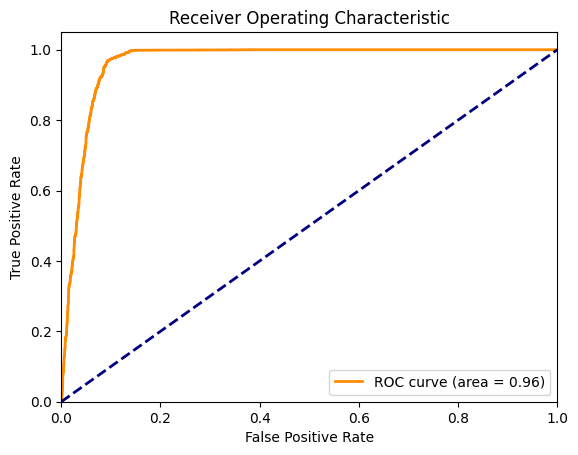

In [ ]:
clf.train_cnn()
clf.evaluate_cnn()

Epoch 1/10
1442/1442 [==============================] - 19s 12ms/step - loss: 0.4016 - accuracy: 0.8053 - val_loss: 0.2858 - val_accuracy: 0.8868
Epoch 2/10
1442/1442 [==============================] - 16s 11ms/step - loss: 0.2714 - accuracy: 0.8954 - val_loss: 0.2275 - val_accuracy: 0.9180
Epoch 3/10
1442/1442 [==============================] - 15s 11ms/step - loss: 0.2299 - accuracy: 0.9166 - val_loss: 0.1789 - val_accuracy: 0.9393
Epoch 4/10
1442/1442 [==============================] - 15s 10ms/step - loss: 0.2044 - accuracy: 0.9293 - val_loss: 0.2321 - val_accuracy: 0.9283
Epoch 5/10
1442/1442 [==============================] - 17s 12ms/step - loss: 0.1941 - accuracy: 0.9339 - val_loss: 0.1865 - val_accuracy: 0.9324
Epoch 6/10
1442/1442 [==============================] - 16s 11ms/step - loss: 0.1812 - accuracy: 0.9390 - val_loss: 0.1813 - val_accuracy: 0.9336
Epoch 7/10
1442/1442 [==============================] - 15s 11ms/step - loss: 0.1746 - accuracy: 0.9414 - val_loss: 0.1522 -

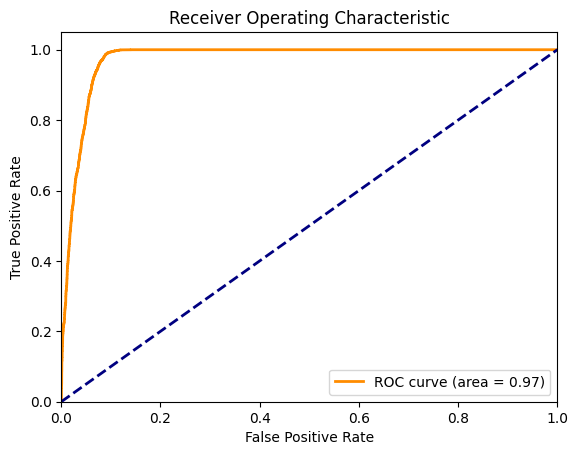

In [ ]:
clf.train_lstm()
clf.evaluate_lstm()

Epoch 1/10
1442/1442 [==============================] - 4s 2ms/step - loss: 0.3595 - accuracy: 0.8685 - val_loss: 0.2373 - val_accuracy: 0.9309
Epoch 2/10
1442/1442 [==============================] - 3s 2ms/step - loss: 0.2251 - accuracy: 0.9282 - val_loss: 0.1985 - val_accuracy: 0.9402
Epoch 3/10
1442/1442 [==============================] - 4s 3ms/step - loss: 0.2022 - accuracy: 0.9347 - val_loss: 0.1820 - val_accuracy: 0.9432
Epoch 4/10
1442/1442 [==============================] - 4s 3ms/step - loss: 0.1896 - accuracy: 0.9386 - val_loss: 0.1721 - val_accuracy: 0.9452
Epoch 5/10
1442/1442 [==============================] - 3s 2ms/step - loss: 0.1812 - accuracy: 0.9412 - val_loss: 0.1656 - val_accuracy: 0.9469
Epoch 6/10
1442/1442 [==============================] - 3s 2ms/step - loss: 0.1755 - accuracy: 0.9427 - val_loss: 0.1604 - val_accuracy: 0.9488
Epoch 7/10
1442/1442 [==============================] - 3s 2ms/step - loss: 0.1704 - accuracy: 0.9441 - val_loss: 0.1549 - val_accuracy:

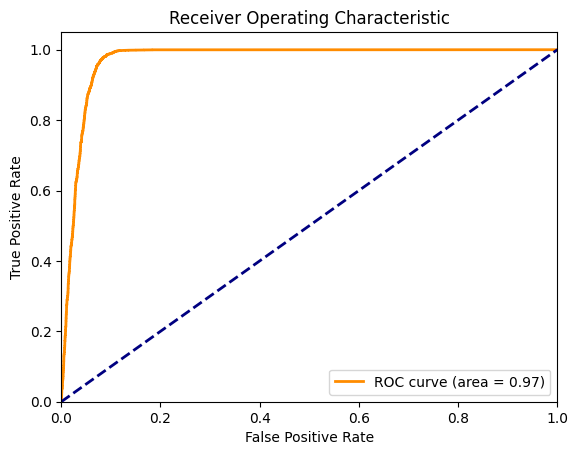

In [ ]:
clf.train_fcn()
clf.evaluate_fcn()

#FCN TPR: 0.9899869960988297 (0.09% FPR)
#Maximum TPR with FPR <= 0.01:  0.9260078023407022

Epoch 1/10
1442/1442 [==============================] - 16s 10ms/step - loss: 0.3070 - accuracy: 0.8682 - val_loss: 0.2207 - val_accuracy: 0.9100
Epoch 2/10
1442/1442 [==============================] - 13s 9ms/step - loss: 0.2113 - accuracy: 0.9258 - val_loss: 0.1927 - val_accuracy: 0.9309
Epoch 3/10
1442/1442 [==============================] - 14s 10ms/step - loss: 0.1907 - accuracy: 0.9351 - val_loss: 0.1680 - val_accuracy: 0.9469
Epoch 4/10
1442/1442 [==============================] - 13s 9ms/step - loss: 0.1813 - accuracy: 0.9386 - val_loss: 0.1536 - val_accuracy: 0.9507
Epoch 5/10
1442/1442 [==============================] - 12s 8ms/step - loss: 0.1713 - accuracy: 0.9418 - val_loss: 0.1473 - val_accuracy: 0.9542
Epoch 6/10
1442/1442 [==============================] - 13s 9ms/step - loss: 0.1612 - accuracy: 0.9450 - val_loss: 0.1435 - val_accuracy: 0.9506
Epoch 7/10
1442/1442 [==============================] - 13s 9ms/step - loss: 0.1510 - accuracy: 0.9481 - val_loss: 0.1286 - val_

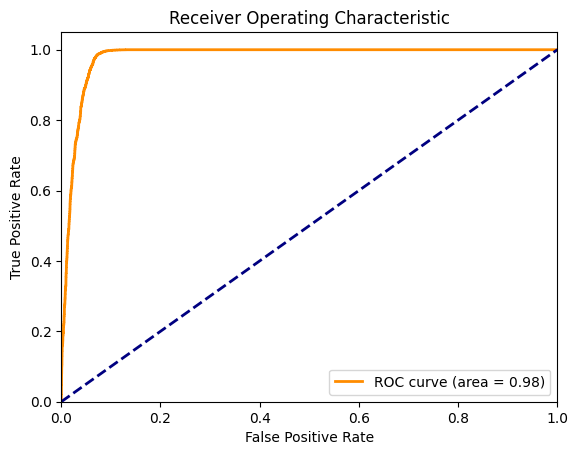

In [ ]:
clf.train_cnn_lstm()
clf.evaluate_cnn_lstm()

#CNN-LSTM TPR: 0.9947984395318595 (10 Percent FPR)
#Maximum TPR with FPR <= 0.01:  0.9433029908972692

Epoch 1/10
1442/1442 [==============================] - 21s 13ms/step - loss: 0.2684 - accuracy: 0.8950 - val_loss: 0.2061 - val_accuracy: 0.9233
Epoch 2/10
1442/1442 [==============================] - 12s 8ms/step - loss: 0.1686 - accuracy: 0.9425 - val_loss: 0.1444 - val_accuracy: 0.9524
Epoch 3/10
1442/1442 [==============================] - 9s 6ms/step - loss: 0.1538 - accuracy: 0.9476 - val_loss: 0.1250 - val_accuracy: 0.9566
Epoch 4/10
1442/1442 [==============================] - 10s 7ms/step - loss: 0.1390 - accuracy: 0.9530 - val_loss: 0.1384 - val_accuracy: 0.9510
Epoch 5/10
1442/1442 [==============================] - 10s 7ms/step - loss: 0.1371 - accuracy: 0.9538 - val_loss: 0.1304 - val_accuracy: 0.9547
Epoch 6/10
1442/1442 [==============================] - 9s 6ms/step - loss: 0.1331 - accuracy: 0.9560 - val_loss: 0.1121 - val_accuracy: 0.9635
Epoch 7/10
1442/1442 [==============================] - 11s 8ms/step - loss: 0.1290 - accuracy: 0.9564 - val_loss: 0.1176 - val_acc

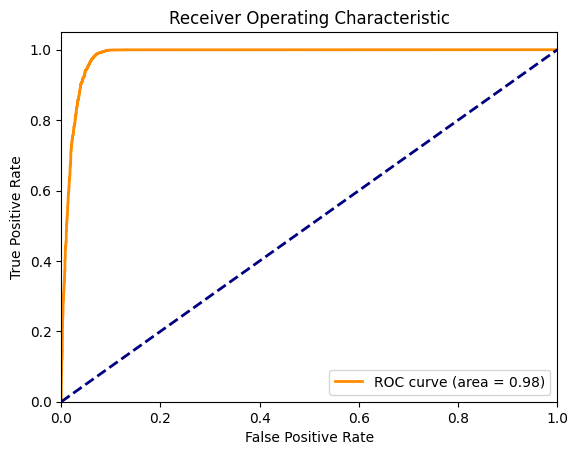

In [ ]:
clf.train_rnn()
clf.evaluate_rnn()

#RNN TPR: 0.9849154746423927 (0.015%)
#Maximum TPR with FPR <= 0.01:  0.9837451235370611

Epoch 1/10
1442/1442 [==============================] - 4s 2ms/step - loss: 0.2636 - accuracy: 0.9091 - val_loss: 0.1833 - val_accuracy: 0.9394
Epoch 2/10
1442/1442 [==============================] - 4s 3ms/step - loss: 0.1846 - accuracy: 0.9390 - val_loss: 0.1653 - val_accuracy: 0.9486
Epoch 3/10
1442/1442 [==============================] - 5s 3ms/step - loss: 0.1681 - accuracy: 0.9440 - val_loss: 0.1505 - val_accuracy: 0.9492
Epoch 4/10
1442/1442 [==============================] - 3s 2ms/step - loss: 0.1589 - accuracy: 0.9470 - val_loss: 0.1383 - val_accuracy: 0.9544
Epoch 5/10
1442/1442 [==============================] - 3s 2ms/step - loss: 0.1493 - accuracy: 0.9490 - val_loss: 0.1433 - val_accuracy: 0.9529
Epoch 6/10
1442/1442 [==============================] - 4s 3ms/step - loss: 0.1415 - accuracy: 0.9510 - val_loss: 0.1302 - val_accuracy: 0.9559
Epoch 7/10
1442/1442 [==============================] - 4s 3ms/step - loss: 0.1343 - accuracy: 0.9534 - val_loss: 0.1206 - val_accuracy:

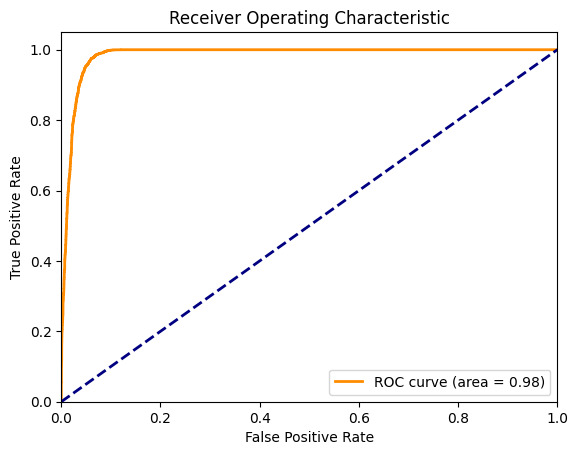

In [ ]:
clf.train_ann()
clf.evaluate_ann()

#ANN TPR: 0.9876462938881665 (8.4%)
#Maximum TPR with FPR <= 0.01:  0.9677503250975292

In [ ]:
clf.train_rf()
clf.evaluate_rf()

#RF TPR: 0.9942782834850455

RF accuracy: 0.9899869960988297
RF confusion matrix:
 [[7570  120]
 [  34 7656]]
RF classification report:
               precision    recall  f1-score   support

         0.0     0.9955    0.9844    0.9899      7690
         1.0     0.9846    0.9956    0.9900      7690

    accuracy                         0.9900     15380
   macro avg     0.9900    0.9900    0.9900     15380
weighted avg     0.9900    0.9900    0.9900     15380

RF TPR: 0.9955786736020806
RF FPR: 0.015604681404421327
